# Monte-Carlo-Simulation

### Config

In [6]:
PATH = "./example_portfolio.csv"
RHO = 0.0
N_SIMS = 10_000

### Modules

In [7]:
import ctypes
import matplotlib.pyplot as plt
import numpy as np

### C-Interface

In [8]:
class Config(ctypes.Structure):
    _fields_ = [
        ("path", ctypes.c_char * 1024),
        ("rho", ctypes.c_float),
        ("n_sims", ctypes.c_size_t),
    ]

class Result(ctypes.Structure):
    _fields_ = [
        ("ms", ctypes.c_float),
        ("L_PF", ctypes.POINTER(ctypes.c_float)),
        ("LR_PF", ctypes.POINTER(ctypes.c_float)),
        ("portfolio_size", ctypes.c_size_t)
    ]

libmonte = ctypes.CDLL("./libmerton.so")
libmonte.simulate.argtypes = [Config]
libmonte.simulate.restype = Result

### Simulate

In [9]:
config = Config(PATH.encode("utf-8"), RHO, N_SIMS)
result = libmonte.simulate(config)
l_pf = [float(result.L_PF[i]) for i in range(result.portfolio_size)]
lr_pf = [float(result.LR_PF[i]) for i in range(result.portfolio_size)]

print(f"{N_SIMS} simulations took {result.ms:.2f} ms")
print(f"path: {PATH}")
print(f"portfolio_size: {result.portfolio_size}")

10000 simulations took 44.55 ms
path: ./example_portfolio.csv
portfolio_size: 80


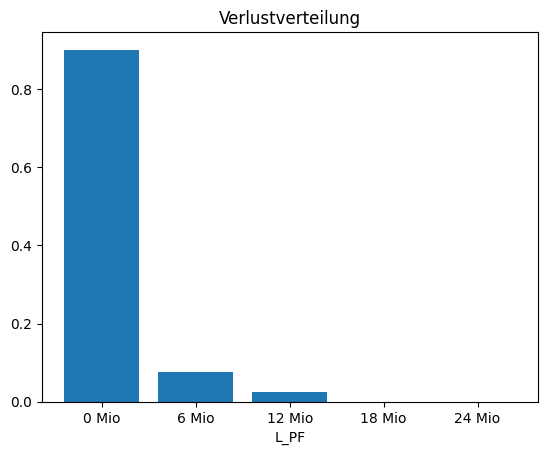

In [10]:
fig, ax = plt.subplots()
ax.set_title(f"Verlustverteilung")
hist, bin_edges = np.histogram(l_pf, bins=[0, 6000, 12000, 18000, 24000, 30000])
names = bin_edges = [f"{int(e/1_000)} Mio" for e in bin_edges[:-1]]
rel_amount = hist/np.sum(hist)
ax.bar(names, rel_amount)
ax.set_xlabel("L_PF")
plt.show()